In [137]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

Site structure has certan structure

1 main page

2 city page

3 neighborhood page

4 home page

5 apartment page

++ supplimentary pages as faq/about us/ etc

We want to try estimate visitors path to registration and path that leads to drop-off

### Read visitor actions from segment
* hidden url

In [138]:
df = pd.read_csv(hidden_url_1)
df['received_at'] = pd.to_datetime(df.received_at)
df['received_at'] = df['received_at'].dt.tz_localize(None)
display(df.columns)
df.sample(3)[['received_at', 'anonymous_id', 'action', 'action_to', 'event',
       'event_text', 'features', 'field_name', 'field_value', 'event_type']]

Index(['received_at', 'anonymous_id', 'action', 'action_to', 'event',
       'event_text', 'features', 'field_name', 'field_value',
       'context_page_title', 'context_page_url', 'event_type'],
      dtype='object')

,received_at,anonymous_id,action,action_to,event,event_text,features,field_name,field_value,event_type
110633,2021-08-12 23:21:00,4005d59f-7c5d-44ac-a9e0-0afe1bee51fe,-,-,-,-,-,-,-,page
8001,2021-10-12 00:26:00,04bc24b5-8f78-46dd-a280-2b1e5081562f,-,-,-,-,-,-,-,page
8463,2021-09-30 21:28:00,051d92ad-624b-42c0-8ebc-3058d26666bf,-,-,-,-,-,-,-,page


Read page mapping. Particular url -> page type 
* hidden url

In [139]:
page_types_df = pd.read_csv(hidden_url_2)
page_types_df.sample(5)

,slug,page_type
1381,1667,room
2812,1876,room
2728,1942,room
970,220,room
897,2029,room


We can define visitor registration event as visiting page journey (visitor redirected there).


In [140]:
users_sign_up = df[df['context_page_url'].str.contains('/journey')][['received_at', 'anonymous_id']]
users_sign_up.rename(columns={'received_at':'time_sign_up'}, inplace=True)
users_sign_up = users_sign_up.sort_values('time_sign_up').drop_duplicates('anonymous_id')

Also important define drop-off event, as negative scenario.

Here we'll take just last visited page + 1 min.

In [141]:
users_drop_off = df.sort_values('received_at', ascending=False).drop_duplicates('anonymous_id')
users_drop_off['received_at'] = users_drop_off['received_at'] + timedelta(seconds=60)
users_drop_off['event_type'] = 'drop_off'

In [142]:
df.shape, users_sign_up.shape, users_drop_off.shape

((438923, 12), (10161, 2), (53673, 12))

We may have more granular event definition, not just city-home, but particular homes and cities.

Derive from URL

In [161]:
df['event_type'] = df['context_page_url'].apply(lambda x: x.split('/')[-1].split('?')[0])

drop-off is extra action so UNION

In [144]:
df = pd.concat([df, users_drop_off])

Registration in extra column so JOIN

In [145]:
df = df.merge(users_sign_up, how='left', on='anonymous_id')
df['is_lead'] = df.time_sign_up.notna()

In [146]:
df.shape

(492596, 14)

Now we are interested only in visitors path before registration. We need to filter out events that happen after registration

In [147]:
df = df[(df['received_at'] <= df['time_sign_up'])|(df['time_sign_up'].isna())]

In [148]:
df = df.merge(page_types_df, how='left', left_on='event_type', right_on='slug')
df.loc[df['page_type'].isna(), 'page_type'] = df.loc[df['page_type'].isna(), 'event_type']

now we have 2 columns of interest event_type and page_type

How many pages views visitor.

To remember that we added drop-off as event, so -1 to all counts

In [149]:
pages_per_visitor = df.anonymous_id.value_counts().value_counts()
pages_per_visitor.index = pages_per_visitor.index -1 
pages_per_visitor.head(10)

1    15055
2     9807
3     5670
4     4533
5     2972
6     2424
7     1723
8     1424
0     1415
9     1132
Name: anonymous_id, dtype: int64

<AxesSubplot:>

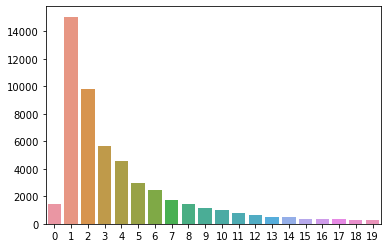

In [150]:
sns.barplot(x=pages_per_visitor.head(20).index, y=pages_per_visitor.head(20).values)

In [151]:
df.sort_values('received_at', inplace=True)

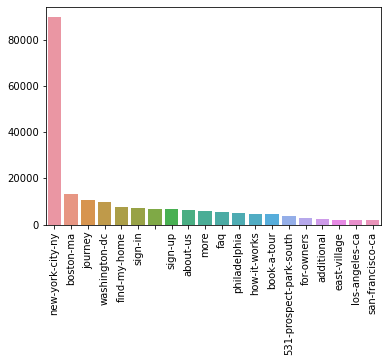

In [167]:
sns.barplot(x=df.event_type.value_counts().head(20).index, y=df.event_type.value_counts().head(20).values)
plt.xticks(rotation=90);

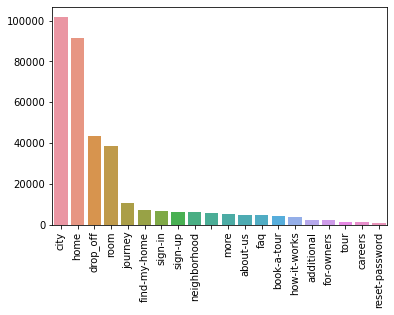

In [168]:
sns.barplot(x=df.page_type.value_counts().head(20).index, y=df.page_type.value_counts().head(20).values)
plt.xticks(rotation=90);

In [169]:
df['event_path'] = df.groupby('anonymous_id')['event_type'].transform('->'.join)

In [170]:
df['pages_path'] = df.groupby('anonymous_id')['page_type'].transform('->'.join)

Now row in our dataFrame is event, let's swith to visitor

In [175]:
user_df = df.drop_duplicates('anonymous_id')
user_df.is_lead.value_counts()

False    43512
True     10161
Name: is_lead, dtype: int64

In [176]:
user_df.is_lead.value_counts(normalize=True)

False    0.810687
True     0.189313
Name: is_lead, dtype: float64

~19% average conversion

Let's analyze the path for not converting visitors

In [177]:
user_df[user_df['is_lead'] == False]['path'].value_counts().head(20)

new-york-city-ny->drop_off                                        6055
boston-ma->drop_off                                                723
about-us->drop_off                                                 657
new-york-city-ny->new-york-city-ny->drop_off                       646
washington-dc->drop_off                                            534
sign-in->drop_off                                                  298
how-it-works->drop_off                                             291
careers->drop_off                                                  257
los-angeles-ca->drop_off                                           251
philadelphia->drop_off                                             249
faq->drop_off                                                      244
for-owners->drop_off                                               210
san-francisco-ca->drop_off                                         192
more->drop_off                                                     153
->drop

Path `sign-in->drop_off` seem to be strange, we need to investigate why people started sign-in/up but left

In [178]:
user_df[user_df['is_lead'] == True]['path'].value_counts().head(20)

journey                                   1414
sign-in->journey                           304
sign-up->journey                           204
journey->sign-in                           165
additional->journey                        142
new-york-city-ny->journey                  127
book-a-tour->journey                        95
journey->additional                         86
new-york-city-ny->sign-up->journey          71
journey->sign-up                            69
journey->new-york-city-ny                   60
sign-in->sign-up->journey                   43
new-york-city-ny->book-a-tour->journey      42
sign-up->sign-in->journey                   39
new-york-city-ny->journey->sign-up          34
new-york-city-ny->sign-in->journey          27
sign-in->new-york-city-ny->journey          27
more->sign-in->journey                      25
reset-password->journey                     24
new-york-city-ny->journey->sign-in          23
Name: path, dtype: int64

That's very suspicious that we have a huge number of leads who visited only the journey page. Maybe it's old visitors, who registered before we started to collect clickstream. Let's get rid of them

In [182]:
user_df = user_df[~(user_df.path == 'journey')]

In [185]:
user_df[user_df['is_lead'] == True]['path'].value_counts().head(5)

sign-in->journey             304
sign-up->journey             204
journey->sign-in             165
additional->journey          142
new-york-city-ny->journey    127
Name: path, dtype: int64

In [186]:
user_df.is_lead.value_counts(normalize=True)

False    0.832622
True     0.167378
Name: is_lead, dtype: float64

Conversion worsen a little

In [191]:
user_df.is_lead.value_counts()

False    43512
True      8747
Name: is_lead, dtype: int64

In [192]:
user_df[user_df['is_lead'] == False]['pages_path'].value_counts().head(10)

city->drop_off                8004
home->drop_off                2110
home->city->drop_off          1614
city->home->drop_off          1123
city->city->drop_off          1043
about-us->drop_off             657
city->home->city->drop_off     411
room->drop_off                 391
neighborhood->drop_off         381
room->home->drop_off           371
Name: pages_path, dtype: int64

In [193]:
user_df[user_df['is_lead'] == True]['pages_path'].value_counts().head(10)

sign-in->journey          304
sign-up->journey          204
journey->sign-in          165
city->journey             149
additional->journey       142
book-a-tour->journey       95
city->sign-up->journey     87
journey->additional        86
journey->city              77
journey->sign-up           69
Name: pages_path, dtype: int64

In [194]:
user_df[user_df['is_lead'] == True]['pages_path'].value_counts(normalize=True).head(10)

sign-in->journey          0.034755
sign-up->journey          0.023322
journey->sign-in          0.018864
city->journey             0.017034
additional->journey       0.016234
book-a-tour->journey      0.010861
city->sign-up->journey    0.009946
journey->additional       0.009832
journey->city             0.008803
journey->sign-up          0.007888
Name: pages_path, dtype: float64

Top 10 paths have less than 15% of total leads, it means tail is very long an it should be analyzed differently

In [220]:
user_df[user_df['is_lead'] == True]['pages_path'].value_counts(normalize=True)[50:70]

profile->journey                      0.001258
journey->sign-in->more                0.001258
city->additional->journey             0.001258
city->journey->book-a-tour            0.001143
home->city->journey                   0.001143
journey->more                         0.001143
sign-up->journey->sign-in             0.001143
journey->sign-in->sign-up             0.001029
city->sign-in->sign-up->journey       0.001029
city->room->journey->book-a-tour      0.001029
city->sign-up->journey->additional    0.001029
city->home->journey                   0.001029
journey->city->additional             0.001029
sign-in->additional->journey          0.001029
journey->home                         0.000915
room->home->journey                   0.000915
journey->more->sign-in                0.000915
city->room->journey->sign-up          0.000915
city->sign-up->home->journey          0.000915
room->journey->book-a-tour            0.000915
Name: pages_path, dtype: float64

lets estimate conversion based on home/room visit

In [221]:
user_df['seen_room'] = user_df.pages_path.str.contains('room')
user_df['seen_home'] = user_df.pages_path.str.contains('home')

In [222]:
user_df.groupby(['seen_home']).is_lead.value_counts(normalize=True)

seen_home  is_lead
False      False      0.830905
           True       0.169095
True       False      0.833950
           True       0.166050
Name: is_lead, dtype: float64

In [223]:
user_df.groupby(['seen_room']).is_lead.value_counts(normalize=True)

seen_room  is_lead
False      False      0.856893
           True       0.143107
True       False      0.758010
           True       0.241990
Name: is_lead, dtype: float64

Visitors how got down to the room level convert much better.


### The overall analysis of the page path gives us very little insight. We need to go down to particular user clicks and filters